## Scrape Shot Charts

In [13]:
from nba_api.stats.endpoints import leaguedashplayerstats

def get_top_players_by_season(season, top_n=10):
    stats = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        season_type_all_star='Regular Season'
    )
    df = stats.get_data_frames()[0]
    top_players = df.nlargest(top_n, 'PTS')[['PLAYER_ID', 'PLAYER_NAME', 'PTS']]
    return top_players

# Exemple pour la saison 2022-23
top_players_2023 = get_top_players_by_season("2022-23")
print(top_players_2023)


     PLAYER_ID              PLAYER_NAME   PTS
238    1628369             Jayson Tatum  2225
251     203954              Joel Embiid  2183
340    1629029              Luka Dončić  2138
463    1628983  Shai Gilgeous-Alexander  2135
166     203507    Giannis Antetokounmpo  1959
23     1630162          Anthony Edwards  1946
281     203944            Julius Randle  1936
132    1628378         Donovan Mitchell  1922
495    1629027               Trae Young  1914
535     203897              Zach LaVine  1913


In [12]:
from nba_api.stats.endpoints import shotchartdetail

def get_shot_chart(player_id, season):
    response = shotchartdetail.ShotChartDetail(
        team_id=0,  # Aucun filtre pour l'équipe
        player_id=player_id,
        season_nullable=season,
        season_type_all_star='Regular Season'
    )
    shot_data = response.get_data_frames()[0]
    return shot_data

# Exemple pour un joueur spécifique
player_id = top_players_2023.iloc[0]['PLAYER_ID']
shot_chart_2023 = get_shot_chart(player_id, "2022-23")
print(shot_chart_2023.shape)


(727, 24)


In [15]:
import random
import time

def get_all_shot_charts(seasons, top_n=10):
    all_data = {}
    for season in seasons:
        print(f"Processing season: {season}")
        top_players = get_top_players_by_season(season, top_n)
        season_data = {}
        for _, player in top_players.iterrows():
            print(f"Fetching data for {player['PLAYER_NAME']} ({season})")
            try:
                shot_chart = get_shot_chart(player['PLAYER_ID'], season)
                season_data[player['PLAYER_NAME']] = shot_chart
                wait = random.uniform(0.0001,0.002)
                time.sleep(wait)
            except Exception as e:
                print(f"Error fetching data for {player['PLAYER_NAME']}: {e}")
        all_data[season] = season_data
    return all_data


current_season = "2023-24"
num_years = 10
start_year = int(current_season.split("-")[0]) - num_years + 1

# Construire la liste des saisons au format NBA
seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(start_year, start_year + num_years)]

# Récupération des données pour plusieurs saisons
#seasons = ["2020-21", "2021-22", "2022-23"]
shot_charts = get_all_shot_charts(seasons)


Processing season: 2014-15
Fetching data for James Harden (2014-15)
Fetching data for Stephen Curry (2014-15)
Fetching data for Russell Westbrook (2014-15)
Fetching data for LeBron James (2014-15)
Fetching data for Damian Lillard (2014-15)
Fetching data for Klay Thompson (2014-15)
Fetching data for LaMarcus Aldridge (2014-15)
Fetching data for Anthony Davis (2014-15)
Fetching data for Kyrie Irving (2014-15)
Fetching data for Chris Paul (2014-15)
Processing season: 2015-16
Fetching data for James Harden (2015-16)
Fetching data for Stephen Curry (2015-16)
Fetching data for Kevin Durant (2015-16)
Fetching data for LeBron James (2015-16)
Fetching data for Damian Lillard (2015-16)
Fetching data for Russell Westbrook (2015-16)
Fetching data for Paul George (2015-16)
Fetching data for DeMar DeRozan (2015-16)
Fetching data for Isaiah Thomas (2015-16)
Fetching data for Klay Thompson (2015-16)
Processing season: 2016-17
Fetching data for Russell Westbrook (2016-17)
Fetching data for James Harden

In [16]:
import os

output_dir = "nba_shot_charts"
os.makedirs(output_dir, exist_ok=True)

for season, players in shot_charts.items():
    season_dir = os.path.join(output_dir, season)
    os.makedirs(season_dir, exist_ok=True)
    for player, df in players.items():
        df.to_csv(os.path.join(season_dir, f"{season}_{player}_shot_chart.csv"), index=False)


## Shot Charts Exemple

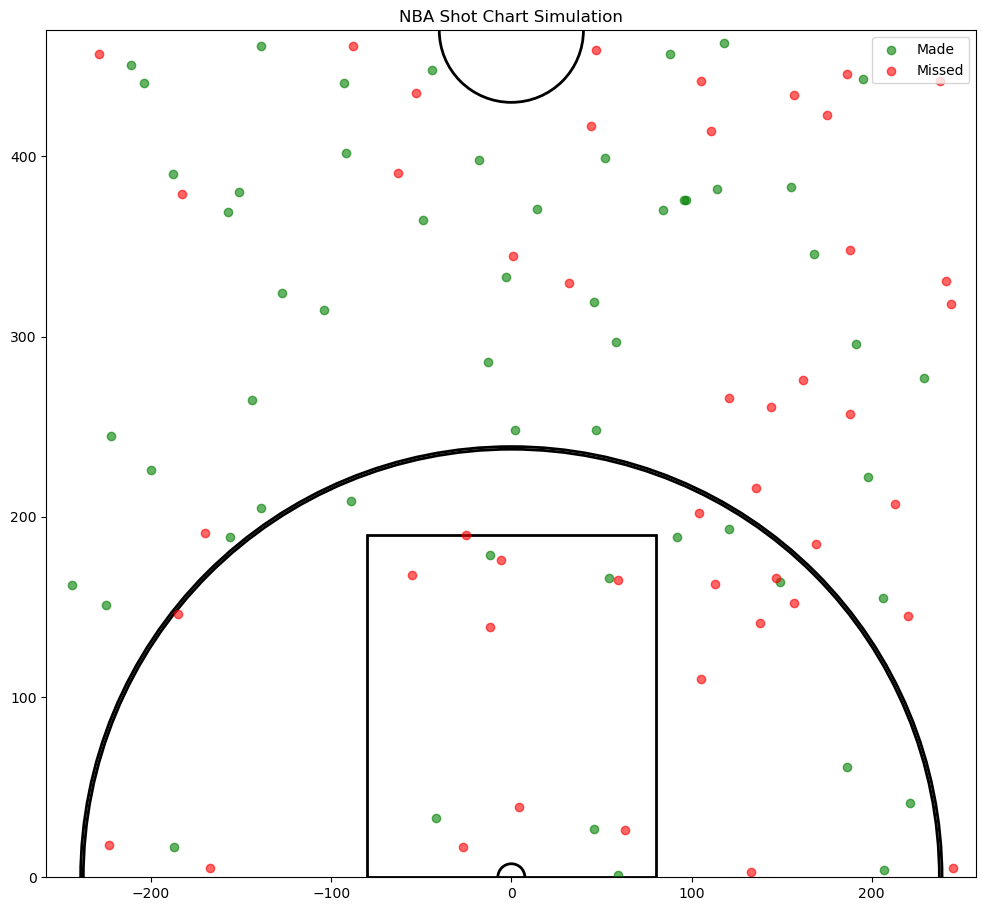

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Exemple fictif de DataFrame avec des données de tirs
data = {
    'LOC_X': np.random.randint(-250, 250, 100),  # Coordonnées x
    'LOC_Y': np.random.randint(0, 470, 100),    # Coordonnées y
    'SHOT_MADE_FLAG': np.random.randint(0, 2, 100)  # Tir réussi ou non
}
df = pd.DataFrame(data)

# Fonction pour dessiner un demi-terrain NBA
def draw_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()
    
    # Dimensions principales
    hoop = plt.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = plt.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    paint = plt.Rectangle((-80, 0), 160, 190, linewidth=lw, color=color, fill=False)
    outer_arc = plt.Circle((0, 0), radius=237.5, linewidth=lw, color=color, fill=False)
    three_point_arc = plt.Circle((0, 0), radius=239, linewidth=lw, color=color, fill=False)
    center_circle = plt.Circle((0, 470), radius=40, linewidth=lw, color=color, fill=False)
    
    # Ajout des formes
    court_elements = [hoop, backboard, paint, outer_arc, three_point_arc, center_circle]
    for element in court_elements:
        ax.add_patch(element)
    
    # Limites du terrain
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    ax.set_aspect('equal', adjustable='datalim')
    return ax

# Visualisation des tirs
plt.figure(figsize=(12, 11))
ax = plt.gca()
draw_court(ax)
made = df[df['SHOT_MADE_FLAG'] == 1]
missed = df[df['SHOT_MADE_FLAG'] == 0]

# Tracer les tirs réussis et manqués
plt.scatter(made['LOC_X'], made['LOC_Y'], c='green', label='Made', alpha=0.6)
plt.scatter(missed['LOC_X'], missed['LOC_Y'], c='red', label='Missed', alpha=0.6)

# Ajouter une légende
plt.legend(loc='upper right')
plt.title("NBA Shot Chart Simulation")
plt.show()


## Scrape BoxScores

In [1]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

def get_games_by_season(season):
    gamefinder = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        season_type_nullable='Regular Season'
    )
    games = gamefinder.get_data_frames()[0]
    
    # Filtrer uniquement les matchs des équipes NBA
    nba_teams = [
        "Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
        "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets",
        "Detroit Pistons", "Golden State Warriors", "Houston Rockets",
        "Indiana Pacers", "LA Clippers", "Los Angeles Lakers", "Memphis Grizzlies",
        "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans",
        "New York Knicks", "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers",
        "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs",
        "Toronto Raptors", "Utah Jazz", "Washington Wizards"
    ]
    
    games = games[games['TEAM_NAME'].isin(nba_teams)]
    return games
# Exemple pour la saison 2023-24
# games_2023 = get_games_by_season("2023-24")
# print(games_2023[['GAME_ID', 'GAME_DATE', 'TEAM_NAME', 'MATCHUP']].shape)


In [2]:
from nba_api.stats.endpoints import boxscoretraditionalv2

def get_boxscore(game_id):
    boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
    player_stats = boxscore.player_stats.get_data_frame()  # Statistiques des joueurs
    team_stats = boxscore.team_stats.get_data_frame()      # Statistiques des équipes
    return player_stats, team_stats

# Exemple avec un GAME_ID spécifique
# game_id = "0022200001"  # Exemple de GAME_ID
# player_stats, team_stats = get_boxscore(game_id)
# print(player_stats.head())


In [3]:

import os
from tqdm import tqdm
import random
import time

def get_all_boxscores(seasons):
    all_boxscores = {}
    for season in (seasons):
        print(f"Processing season: {season}")
        games = get_games_by_season(season)
        season_boxscores = []
        n = 0
        for game_id in tqdm(games['GAME_ID']):
            print(f"Fetching boxscore for GAME_ID: {game_id}")
            try:
                player_stats, team_stats = get_boxscore(game_id)
                season_boxscores.append({
                    'GAME_ID': game_id,
                    'player_stats': player_stats,
                    'team_stats': team_stats
                })
                if n < 1500 :
                    wait = random.uniform(0.0001,0.01)
                    time.sleep(wait)
                else :
                    wait = random.uniform(0.01,0.05)
                    time.sleep(wait)
                    
                n += 1
                if n% 100 == 0:
                    print(f"{n} games have been scraped dans la saison {season}")
            except Exception as e:
                print(f"Error fetching boxscore for GAME_ID {game_id}: {e}")
        
        all_boxscores[season] = season_boxscores
    return all_boxscores

# Exemple pour les 10 dernières saisons
seasons = ["2022-23"]
    # "2013-14", "2014-15", "2015-16", "2016-17", "2017-18", 
    #        "2018-19", "2019-20", "2020-21", "2021-22", "2022-23"]
boxscores = get_all_boxscores(seasons)

output_dir = "nba_boxscores"
os.makedirs(output_dir, exist_ok=True)

for season, games in boxscores.items():
    season_dir = os.path.join(output_dir, season)
    os.makedirs(season_dir, exist_ok=True)
    for game in games:
        player_stats_file = os.path.join(season_dir, f"{game['GAME_ID']}_player_stats.csv")
        team_stats_file = os.path.join(season_dir, f"{game['GAME_ID']}_team_stats.csv")
    
        game['player_stats'].to_csv(player_stats_file, index=False)
        game['team_stats'].to_csv(team_stats_file, index=False)


Processing season: 2022-23


  0%|          | 1/2460 [00:00<04:07,  9.95it/s]

Fetching boxscore for GAME_ID: 0022201222
Fetching boxscore for GAME_ID: 0022201224


  0%|          | 3/2460 [00:00<04:26,  9.22it/s]

Fetching boxscore for GAME_ID: 0022201218
Fetching boxscore for GAME_ID: 0022201226


  0%|          | 5/2460 [00:30<5:14:14,  7.68s/it]

Error fetching boxscore for GAME_ID 0022201226: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Fetching boxscore for GAME_ID: 0022201229
Fetching boxscore for GAME_ID: 0022201218


  0%|          | 7/2460 [00:49<5:20:47,  7.85s/it]

Error fetching boxscore for GAME_ID 0022201218: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching boxscore for GAME_ID: 0022201220
Fetching boxscore for GAME_ID: 0022201221
Fetching boxscore for GAME_ID: 0022201216


  0%|          | 9/2460 [00:50<2:47:26,  4.10s/it]

Fetching boxscore for GAME_ID: 0022201228


  0%|          | 11/2460 [01:20<5:22:27,  7.90s/it]

Error fetching boxscore for GAME_ID 0022201228: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Fetching boxscore for GAME_ID: 0022201221
Fetching boxscore for GAME_ID: 0022201223


  1%|          | 13/2460 [01:39<5:24:40,  7.96s/it]

Error fetching boxscore for GAME_ID 0022201223: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching boxscore for GAME_ID: 0022201225
Fetching boxscore for GAME_ID: 0022201219
Fetching boxscore for GAME_ID: 0022201227


  1%|          | 14/2460 [01:58<5:46:24,  8.50s/it]


KeyboardInterrupt: 

In [4]:
import os

# folder path
dir_path = r'C:\Users\carlf\Documents\GitHub\The_Great_MVP_Predictor\nba_boxscores\2023-24'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    file_path = os.path.join(dir_path, path)
    if os.path.isfile(file_path):
        
        if path.startswith('2'):
            try:
                # Delete the file
                os.remove(file_path)
                print(f"Deleted: {path}")
            except Exception as e:
                print(f"Error deleting {path}: {e}")
            count += 1
print('File count:', count)

Deleted: 2022300123_player_stats.csv
Deleted: 2022300123_team_stats.csv
Deleted: 2022300141_player_stats.csv
Deleted: 2022300141_team_stats.csv
Deleted: 2022300143_player_stats.csv
Deleted: 2022300143_team_stats.csv
Deleted: 2022300147_player_stats.csv
Deleted: 2022300147_team_stats.csv
Deleted: 2022300148_player_stats.csv
Deleted: 2022300148_team_stats.csv
Deleted: 2022300149_player_stats.csv
Deleted: 2022300149_team_stats.csv
Deleted: 2022300150_player_stats.csv
Deleted: 2022300150_team_stats.csv
Deleted: 2022300151_player_stats.csv
Deleted: 2022300151_team_stats.csv
Deleted: 2022300152_player_stats.csv
Deleted: 2022300152_team_stats.csv
Deleted: 2022300153_player_stats.csv
Deleted: 2022300153_team_stats.csv
Deleted: 2022300154_player_stats.csv
Deleted: 2022300154_team_stats.csv
Deleted: 2022300155_player_stats.csv
Deleted: 2022300155_team_stats.csv
Deleted: 2022300156_player_stats.csv
Deleted: 2022300156_team_stats.csv
Deleted: 2022300157_player_stats.csv
Deleted: 2022300157_team_st

## Scrape Stats and Advanced Stats

In [1]:
import requests
import os
import shutil
from tqdm import tqdm
from bs4 import BeautifulSoup
import time
import random
import pandas as pd

In [2]:
years = list(range(1980,2026))

In [57]:

url_start = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}
for year in tqdm(years):
    url = url_start.format(year)
    
    data = requests.get(url, headers=headers)
    
    with open("stats/{}.html".format(year), "w+") as f:
        f.write(data.text)
    wait = random.randint(5,10)
    time.sleep(wait)
    #print(f"Waited for {wait} seconds before continuing !")

100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


In [58]:
df_list = {}
for year in tqdm(years):
    with open("stats/{}.html".format(year)) as f:
        page = f.read()
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header")
    stat_table = soup.find_all(id="per_game_stats")
    stat = pd.read_html(str(stat_table))[0]
    
    df_list[year] = {'year': year, 'stat': stat}
    wait = random.randint(3,7)
    time.sleep(wait + 1)

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\carlf\AppData\Local\Temp\ipykernel_23428\1692216676.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


In [ ]:
import requests
import random
import time
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd

url_start = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

df_list = {}
for year in tqdm(years):
    url = url_start.format(year)
    
    response = requests.get(url, headers=headers)
    wait_time = random.uniform(3, 5)
    time.sleep(wait_time)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    stat_table = soup.find(id="per_game_stats")
    if stat_table is not None:
        stat = pd.read_html(str(stat_table))[0]
        df_list[year] = {'year': year, 'stat': stat}
    
    wait_time = random.uniform(0.5, 1.5)
    time.sleep(wait_time + 1)

  0%|          | 0/46 [00:00<?, ?it/s]

Waited for 4.55 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  2%|▏         | 1/46 [00:08<06:04,  8.09s/it]

Waited for 4.81 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  4%|▍         | 2/46 [00:15<05:50,  7.96s/it]

Waited for 3.97 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  7%|▋         | 3/46 [00:23<05:31,  7.70s/it]

Waited for 4.16 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  9%|▊         | 4/46 [00:30<05:16,  7.54s/it]

Waited for 3.50 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 11%|█         | 5/46 [00:38<05:09,  7.54s/it]

Waited for 3.85 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 13%|█▎        | 6/46 [00:45<04:59,  7.48s/it]

Waited for 4.81 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 15%|█▌        | 7/46 [00:54<05:09,  7.95s/it]

Waited for 3.54 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 17%|█▋        | 8/46 [01:01<04:53,  7.74s/it]

Waited for 4.18 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 20%|█▉        | 9/46 [01:10<04:55,  7.98s/it]

Waited for 3.71 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 22%|██▏       | 10/46 [01:17<04:37,  7.71s/it]

Waited for 4.26 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 24%|██▍       | 11/46 [01:25<04:37,  7.92s/it]

Waited for 3.51 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 26%|██▌       | 12/46 [01:33<04:23,  7.75s/it]

Waited for 4.72 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 28%|██▊       | 13/46 [01:42<04:31,  8.24s/it]

Waited for 4.47 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 30%|███       | 14/46 [01:51<04:28,  8.38s/it]

Waited for 3.85 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 33%|███▎      | 15/46 [02:00<04:25,  8.56s/it]

Waited for 3.23 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 35%|███▍      | 16/46 [02:07<04:04,  8.15s/it]

Waited for 4.64 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 37%|███▋      | 17/46 [02:16<04:02,  8.38s/it]

Waited for 4.89 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 39%|███▉      | 18/46 [02:25<04:02,  8.66s/it]

Waited for 4.41 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 41%|████▏     | 19/46 [02:34<03:53,  8.65s/it]

Waited for 3.14 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 43%|████▎     | 20/46 [02:41<03:31,  8.15s/it]

Waited for 4.47 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 46%|████▌     | 21/46 [02:49<03:27,  8.32s/it]

Waited for 4.08 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 48%|████▊     | 22/46 [02:58<03:18,  8.27s/it]

Waited for 3.94 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 50%|█████     | 23/46 [03:05<03:06,  8.12s/it]

Waited for 4.09 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 52%|█████▏    | 24/46 [03:14<03:00,  8.19s/it]

Waited for 3.79 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 54%|█████▍    | 25/46 [03:22<02:52,  8.22s/it]

Waited for 3.58 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 57%|█████▋    | 26/46 [03:30<02:41,  8.08s/it]

Waited for 3.75 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 59%|█████▊    | 27/46 [03:38<02:34,  8.13s/it]

Waited for 4.06 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 61%|██████    | 28/46 [03:46<02:27,  8.18s/it]

Waited for 3.28 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 63%|██████▎   | 29/46 [03:54<02:15,  7.96s/it]

Waited for 4.96 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 65%|██████▌   | 30/46 [04:03<02:12,  8.30s/it]

Waited for 4.04 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 67%|██████▋   | 31/46 [04:11<02:02,  8.16s/it]

Waited for 4.23 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 70%|██████▉   | 32/46 [04:20<01:58,  8.47s/it]

Waited for 3.83 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 72%|███████▏  | 33/46 [04:28<01:49,  8.40s/it]

Waited for 4.33 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 74%|███████▍  | 34/46 [04:37<01:41,  8.47s/it]

Waited for 4.77 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 76%|███████▌  | 35/46 [04:46<01:35,  8.68s/it]

Waited for 4.06 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 78%|███████▊  | 36/46 [04:54<01:25,  8.56s/it]

Waited for 3.50 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 80%|████████  | 37/46 [05:01<01:13,  8.17s/it]

Waited for 4.67 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 83%|████████▎ | 38/46 [05:11<01:08,  8.61s/it]

Waited for 3.03 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 85%|████████▍ | 39/46 [05:18<00:57,  8.22s/it]

Waited for 4.65 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 87%|████████▋ | 40/46 [05:28<00:51,  8.54s/it]

Waited for 3.78 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 89%|████████▉ | 41/46 [05:36<00:42,  8.46s/it]

Waited for 4.86 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 91%|█████████▏| 42/46 [05:46<00:35,  8.79s/it]

Waited for 3.60 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 93%|█████████▎| 43/46 [05:54<00:25,  8.56s/it]

Waited for 4.49 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 96%|█████████▌| 44/46 [06:03<00:17,  8.77s/it]

Waited for 4.55 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 98%|█████████▊| 45/46 [06:12<00:08,  8.86s/it]

Waited for 3.72 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\3314079466.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
100%|██████████| 46/46 [06:19<00:00,  8.25s/it]


In [8]:
import requests
import random
import time
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import os

url_start = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}


years = list(range(1980,2026))

def scrape_advanced_stats(years:list) :
    
    """_summary_
    """
    df_list = {}
    for year in tqdm(years):
        url = url_start.format(year)
        
        response = requests.get(url, headers=headers)
        wait_time = random.uniform(3, 5)
        time.sleep(wait_time)
        print(f"Waited for {wait_time:.2f} seconds before continuing.")
        
        soup = BeautifulSoup(response.content, 'html.parser')
        stat_table = soup.find(id="advanced_stats")
        if stat_table is not None:
            stat = pd.read_html(str(stat_table))[0]
            df_list[year] = {'year': year, 'stat': stat}
        
        wait_time = random.uniform(0.5, 1.5)
        time.sleep(wait_time + 1)
        
    if not os.path.exists("advanced_stats_csv"):
        os.makedirs("advanced_stats_csv")

    for year, data in df_list.items():
        data['stat'].to_csv(f"advanced_stats_csv/advanced_stat{year}.csv", index=False)
        
scrape_advanced_stats(years)

  0%|          | 0/46 [00:00<?, ?it/s]

Waited for 3.87 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  2%|▏         | 1/46 [00:08<06:11,  8.24s/it]

Waited for 4.59 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  4%|▍         | 2/46 [00:16<05:55,  8.07s/it]

Waited for 4.05 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  7%|▋         | 3/46 [00:23<05:40,  7.92s/it]

Waited for 4.66 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
  9%|▊         | 4/46 [00:32<05:47,  8.27s/it]

Waited for 3.59 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 11%|█         | 5/46 [00:39<05:24,  7.90s/it]

Waited for 3.94 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 13%|█▎        | 6/46 [00:47<05:13,  7.85s/it]

Waited for 3.60 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 15%|█▌        | 7/46 [00:55<04:58,  7.66s/it]

Waited for 3.45 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 17%|█▋        | 8/46 [01:01<04:38,  7.32s/it]

Waited for 4.77 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 20%|█▉        | 9/46 [01:10<04:49,  7.83s/it]

Waited for 3.36 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 22%|██▏       | 10/46 [01:16<04:23,  7.33s/it]

Waited for 4.45 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 24%|██▍       | 11/46 [01:24<04:19,  7.42s/it]

Waited for 4.11 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 26%|██▌       | 12/46 [01:31<04:12,  7.44s/it]

Waited for 3.75 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 28%|██▊       | 13/46 [01:38<04:02,  7.35s/it]

Waited for 4.16 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 30%|███       | 14/46 [01:46<03:58,  7.46s/it]

Waited for 3.53 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 33%|███▎      | 15/46 [01:54<03:49,  7.41s/it]

Waited for 3.56 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 35%|███▍      | 16/46 [02:00<03:35,  7.17s/it]

Waited for 4.40 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 37%|███▋      | 17/46 [02:09<03:38,  7.55s/it]

Waited for 4.72 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 39%|███▉      | 18/46 [02:17<03:41,  7.90s/it]

Waited for 4.58 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 41%|████▏     | 19/46 [02:27<03:46,  8.39s/it]

Waited for 3.27 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 43%|████▎     | 20/46 [02:34<03:30,  8.08s/it]

Waited for 3.60 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 46%|████▌     | 21/46 [02:42<03:20,  8.03s/it]

Waited for 3.59 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 48%|████▊     | 22/46 [02:50<03:08,  7.86s/it]

Waited for 4.54 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 50%|█████     | 23/46 [02:58<03:05,  8.09s/it]

Waited for 3.98 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 52%|█████▏    | 24/46 [03:06<02:56,  8.04s/it]

Waited for 3.40 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 54%|█████▍    | 25/46 [03:14<02:48,  8.02s/it]

Waited for 4.78 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 57%|█████▋    | 26/46 [03:22<02:42,  8.15s/it]

Waited for 3.08 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 59%|█████▊    | 27/46 [03:31<02:36,  8.24s/it]

Waited for 3.26 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 61%|██████    | 28/46 [03:39<02:25,  8.07s/it]

Waited for 3.56 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 63%|██████▎   | 29/46 [03:50<02:34,  9.10s/it]

Waited for 4.69 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 65%|██████▌   | 30/46 [04:00<02:28,  9.29s/it]

Waited for 3.26 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 67%|██████▋   | 31/46 [04:08<02:15,  9.03s/it]

Waited for 4.73 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 70%|██████▉   | 32/46 [04:17<02:04,  8.90s/it]

Waited for 4.20 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 72%|███████▏  | 33/46 [04:25<01:51,  8.60s/it]

Waited for 3.97 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 74%|███████▍  | 34/46 [04:32<01:39,  8.25s/it]

Waited for 3.58 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 76%|███████▌  | 35/46 [04:40<01:30,  8.18s/it]

Waited for 3.33 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 78%|███████▊  | 36/46 [04:48<01:20,  8.04s/it]

Waited for 4.71 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 80%|████████  | 37/46 [04:56<01:13,  8.16s/it]

Waited for 3.09 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 83%|████████▎ | 38/46 [05:03<01:01,  7.68s/it]

Waited for 3.63 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 85%|████████▍ | 39/46 [05:11<00:54,  7.73s/it]

Waited for 4.85 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 87%|████████▋ | 40/46 [05:22<00:52,  8.83s/it]

Waited for 3.17 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 89%|████████▉ | 41/46 [05:31<00:43,  8.67s/it]

Waited for 3.50 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 91%|█████████▏| 42/46 [05:39<00:34,  8.62s/it]

Waited for 3.68 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 93%|█████████▎| 43/46 [05:49<00:26,  8.90s/it]

Waited for 3.07 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 96%|█████████▌| 44/46 [05:58<00:18,  9.07s/it]

Waited for 4.73 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
 98%|█████████▊| 45/46 [06:08<00:09,  9.46s/it]

Waited for 4.77 seconds before continuing.


C:\Users\carlf\AppData\Local\Temp\ipykernel_19412\572246950.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  stat = pd.read_html(str(stat_table))[0]
100%|██████████| 46/46 [06:17<00:00,  8.21s/it]


In [7]:
# Créer le dossier "stat_csv" s'il n'existe pas
if not os.path.exists("stats_csv"):
    os.makedirs("stats_csv")

# Enregistrer les DataFrames dans des fichiers CSV
for year, data in df_list.items():
    data['stat'].to_csv(f"stats_csv/stat_per_game_{year}.csv", index=False)

In [33]:
soup = BeautifulSoup(page, 'html.parser')
soup.find('tr', class_="over_header")

In [46]:
mvp_1991 = pd.read_html(str(mvp_table))[0]

C:\Users\carlf\AppData\Local\Temp\ipykernel_23428\1044145557.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mvp_1991 = pd.read_html(str(mvp_table))[0]


In [48]:
mvp_1991.head(50)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
0,1.0,Michael Jordan,27.0,CHI,SG,82.0,82.0,37.0,12.1,22.4,...,1.4,4.6,6.0,5.5,2.7,1.0,2.5,2.8,31.5,"MVP-1,DPOY-7,AS,NBA1"
1,2.0,Karl Malone,27.0,UTA,PF,82.0,82.0,40.3,10.3,19.6,...,2.9,8.9,11.8,3.3,1.1,1.0,3.0,3.3,29.0,"MVP-5,AS,NBA1"
2,3.0,Bernard King,34.0,WSB,SF,64.0,64.0,37.5,11.1,23.6,...,1.8,3.2,5.0,4.6,0.9,0.3,4.0,2.9,28.4,"MVP-16,AS,NBA3"
3,4.0,Charles Barkley,27.0,PHI,SF,67.0,67.0,37.3,9.9,17.4,...,3.9,6.3,10.1,4.2,1.6,0.5,3.1,2.6,27.6,"MVP-4,AS,NBA1"
4,5.0,Patrick Ewing,28.0,NYK,C,81.0,81.0,38.3,10.4,20.3,...,2.4,8.8,11.2,3.0,1.0,3.2,3.6,3.5,26.6,"MVP-11,DPOY-7,AS,NBA2"
5,6.0,Michael Adams,28.0,DEN,PG,66.0,66.0,35.5,8.5,21.5,...,0.9,3.0,3.9,10.5,2.2,0.1,3.6,2.5,26.5,NaN
6,7.0,Dominique Wilkins,31.0,ATL,SF,81.0,81.0,38.0,9.5,20.2,...,3.2,5.8,9.0,3.3,1.5,0.8,2.5,1.9,25.9,"MVP-8,AS,NBA2"
7,8.0,Chris Mullin,27.0,GSW,SF,82.0,82.0,40.4,9.5,17.7,...,1.7,3.7,5.4,4.0,2.1,0.8,3.0,2.1,25.7,"AS,NBA2"
8,9.0,David Robinson,25.0,SAS,C,82.0,81.0,37.7,9.2,16.7,...,4.1,8.9,13.0,2.5,1.5,3.9,3.3,3.2,25.6,"MVP-3,DPOY-2,AS,NBA1"
9,10.0,Orlando Woolridge,31.0,DEN,SF,53.0,50.0,34.4,9.2,18.5,...,2.7,4.2,6.8,2.2,1.3,0.4,2.9,2.7,25.1,NaN


In [51]:
mvp_1991["Year"] = 1991

In [52]:
mvp_1991.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Michael Jordan,27,CHI,77.0,891.0,960,0.928,82,37.0,...,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991
1,2,Magic Johnson,31,LAL,10.0,497.0,960,0.518,79,37.1,...,7.0,12.5,1.3,0.2,0.477,0.320,0.906,15.4,0.251,1991
2,3,David Robinson,25,SAS,6.0,476.0,960,0.496,82,37.7,...,13.0,2.5,1.5,3.9,0.552,0.143,0.762,17.0,0.264,1991
3,4,Charles Barkley,27,PHI,2.0,222.0,960,0.231,67,37.3,...,10.1,4.2,1.6,0.5,0.570,0.284,0.722,13.4,0.258,1991
4,5,Karl Malone,27,UTA,0.0,142.0,960,0.148,82,40.3,...,11.8,3.3,1.1,1.0,0.527,0.286,0.770,15.5,0.225,1991


In [55]:
dfs = []
for year in years:
    with open("mvp/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    dfs.append(mvp_df)

In [57]:
mvps = pd.concat(dfs)

mvps.tail()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
10,11,Russell Westbrook,32,WAS,0.0,5.0,1010,0.005,65,36.4,...,11.5,11.7,1.4,0.4,0.439,0.315,0.656,3.7,0.075,2021
11,12,Ben Simmons,24,PHI,0.0,3.0,1010,0.003,58,32.4,...,7.2,6.9,1.6,0.6,0.557,0.300,0.613,6.0,0.153,2021
12,13T,James Harden,31,TOT,0.0,1.0,1010,0.001,44,36.6,...,7.9,10.8,1.2,0.8,0.466,0.362,0.861,7.0,0.208,2021
13,13T,LeBron James,36,LAL,0.0,1.0,1010,0.001,45,33.4,...,7.7,7.8,1.1,0.6,0.513,0.365,0.698,5.6,0.179,2021
14,13T,Kawhi Leonard,29,LAC,0.0,1.0,1010,0.001,52,34.1,...,6.5,5.2,1.6,0.4,0.512,0.398,0.885,8.8,0.238,2021


In [91]:
mvps.to_csv("mvps.csv")

In [58]:
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

for year in years:
    url = player_stats_url.format(year)
    
    data = requests.get(url)
    
    with open("player/{}.html".format(year), "w+") as f:
        f.write(data.text)

In [64]:
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

# install selenium chrome driver from https://chromedriver.chromium.org/downloads
# xattr -d com.apple.quarantine chromedriver

In [68]:
driver = webdriver.Chrome(
    executable_path="/Users/vik/chromedriver"
    )

/var/folders/xz/9z84c__j28g8tg28bmcthjj00000gn/T/ipykernel_76608/3988874453.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(


In [67]:
for year in years:
    url = player_stats_url.format(year)
    
    driver.get(url)
    driver.execute_script("window.scrollTo(1,10000)")
    time.sleep(2)
    
    with open("player/{}.html".format(year), "w+") as f:
        f.write(driver.page_source)

In [73]:
dfs = []
for year in years:
    with open("player/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    player_table = soup.find_all(id="per_game_stats")[0]
    player_df = pd.read_html(str(player_table))[0]
    player_df["Year"] = year
    dfs.append(player_df)

In [74]:
players = pd.concat(dfs)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
725,536,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,...,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
726,537,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
727,538,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
728,539,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021
729,540,Ivica Zubac,C,23,LAC,72,33,22.3,3.6,5.5,...,2.6,4.6,7.2,1.3,0.3,0.9,1.1,2.6,9.0,2021


In [76]:
players.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,...,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991
1,2,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,...,0.5,1.3,1.8,3.1,0.8,0.1,1.6,2.2,14.1,1991
2,3,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,...,2.1,3.2,5.3,0.4,0.4,0.4,0.6,3.2,4.2,1991
3,4,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,...,0.9,3.0,3.9,10.5,2.2,0.1,3.6,2.5,26.5,1991
4,5,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,...,1.7,3.1,4.8,1.8,0.6,0.3,1.6,2.7,14.2,1991


In [92]:
players.to_csv("players.csv")

In [77]:
team_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html"

In [78]:
for year in years:
    url = team_stats_url.format(year)
    
    data = requests.get(url)
    
    with open("team/{}.html".format(year), "w+") as f:
        f.write(data.text)

In [86]:
dfs = []
for year in years:
    with open("team/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    e_table = soup.find_all(id="divs_standings_E")[0]
    e_df = pd.read_html(str(e_table))[0]
    e_df["Year"] = year
    e_df["Team"] = e_df["Eastern Conference"]
    del e_df["Eastern Conference"]
    dfs.append(e_df)
    
    w_table = soup.find_all(id="divs_standings_W")[0]
    w_df = pd.read_html(str(w_table))[0]
    w_df["Year"] = year
    w_df["Team"] = w_df["Western Conference"]
    del w_df["Western Conference"]
    dfs.append(w_df)

In [87]:
teams = pd.concat(dfs)

In [88]:
teams.tail()

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
13,42,30,.583,—,112.4,110.2,2.26,2021,Dallas Mavericks*
14,38,34,.528,4.0,113.3,112.3,1.07,2021,Memphis Grizzlies*
15,33,39,.458,9.0,111.1,112.8,-1.58,2021,San Antonio Spurs
16,31,41,.431,11.0,114.6,114.9,-0.20,2021,New Orleans Pelicans
17,17,55,.236,25.0,108.8,116.7,-7.50,2021,Houston Rockets


In [89]:
teams.head()

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics*
1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers*
2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks*
3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets


In [93]:
teams.to_csv("teams.csv")